In [64]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

In [65]:
# -- |Data details| --
participant_id = 2
session = 2
# -- |Data Selection| --
initial_run = 3
n_run = 5

# -- |Event dictionary| --
# Set up your event name
if session == 1 : events_id = {'right': 0, 'left': 1}
else            : events_id = {'none': 0, 'right': 1, 'left': 2}

# **Functions**

## Data Preparation

In [66]:
def streams2mnedata(streams):
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert microvoltage to voltage

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] # Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250,  # OpenBCI Frequency acquistion
        verbose=False
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] # Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))
    
    return raw_mne, events

## Preprocessing

In [67]:
def preprocessing(rawArray):
    # -- |Common Average Reference| --
    mne_car = rawArray.copy().set_eeg_reference('average', verbose=False)

    # -- |Bandpass filter| --
    mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin',picks ='all', verbose=False)

    return mne_alpha

# **Raw Data Overview**

In [68]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    epochs = mne.Epochs(raw_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,228
Events,left: 75none: 78right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


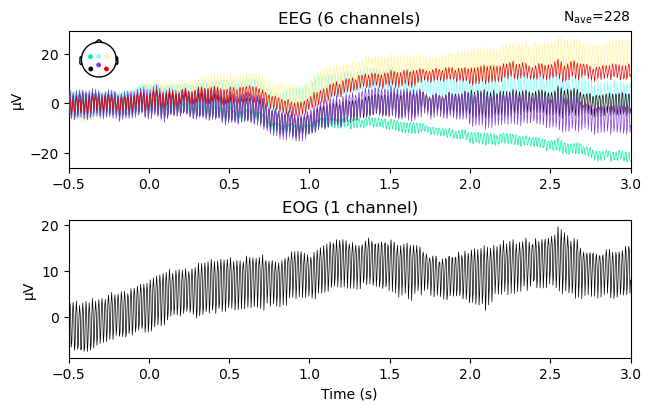

In [69]:
plot_kwargs = dict(picks="all")

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_7900\3855270505.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin=0,fmax=50).plot()
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


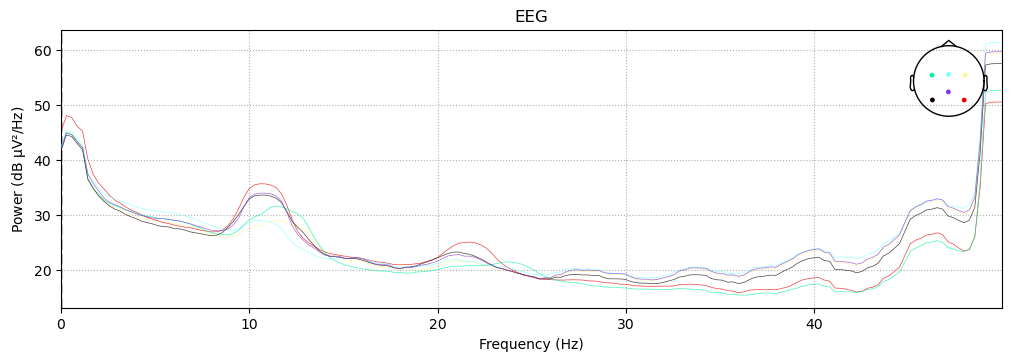

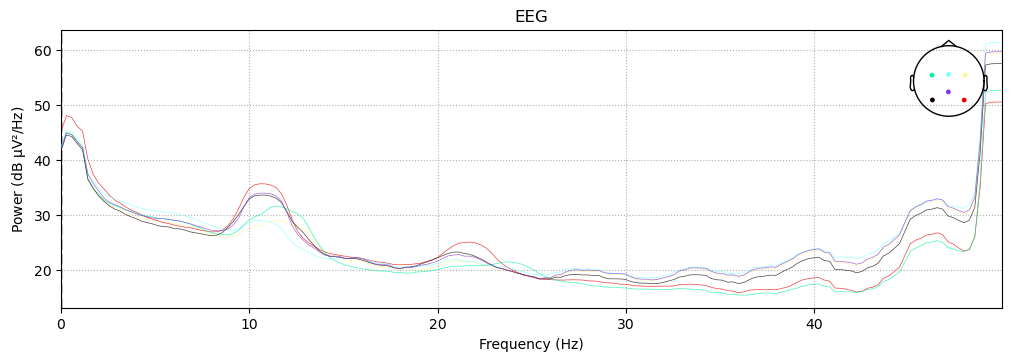

In [70]:
epochs.compute_psd(fmin=0,fmax=50).plot()

# **Processing**

In [71]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    prepro_mne = preprocessing(raw_mne)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(prepro_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,228
Events,left: 75none: 78right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## Part 1: Without artifact removal

### 1.1 Left vs. Right Classification

Train set shape: (120, 7)
Test set shape : (30, 7)


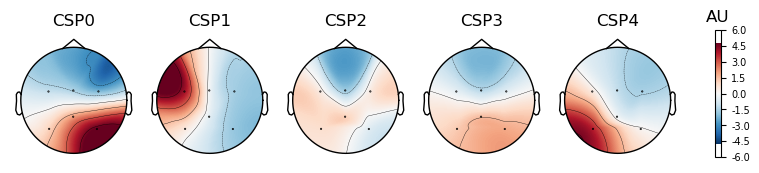

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

       right       0.92      0.73      0.81        15
        left       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [72]:
mne.set_log_level(verbose=False)

# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

csp_list = []
clf_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    clf = Pipeline([('SVM', SVC(kernel='linear'))])  
    clf.fit(X_train, Y_train)
    clf_list.append(clf)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
clf = clf_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.2 Left vs. Non-left Classification

Train set shape: (182, 7)
Test set shape : (46, 7)


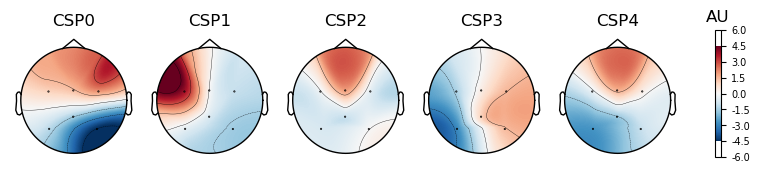

Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

   none-left       0.82      0.90      0.86        31
        left       0.75      0.60      0.67        15

    accuracy                           0.80        46
   macro avg       0.79      0.75      0.76        46
weighted avg       0.80      0.80      0.80        46



In [73]:
epochs_l = epochs.copy()
epochs_l.events = mne.merge_events(epochs_l.events, [0, 1], 0, replace_events=True)
epochs_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_l.get_data(copy=False)
Y = epochs_l.events[:, -1]

csp_list = []
clf_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    clf = Pipeline([('SVM', SVC(kernel='linear'))])  
    clf.fit(X_train, Y_train)
    clf_list.append(clf)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
clf = clf_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.3 Right vs. Non-Right Classification

Train set shape: (182, 7)
Test set shape : (46, 7)


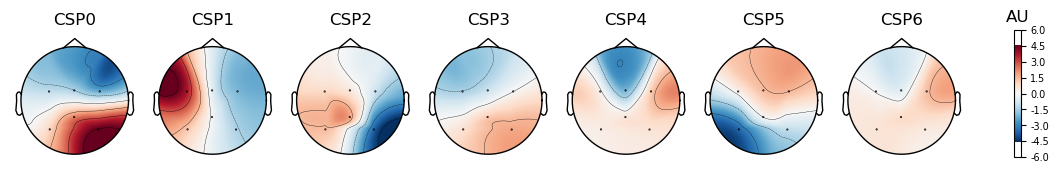

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

  none-right       0.78      0.94      0.85        31
       right       0.78      0.47      0.58        15

    accuracy                           0.78        46
   macro avg       0.78      0.70      0.72        46
weighted avg       0.78      0.78      0.77        46



In [74]:
epochs_r = epochs.copy()
epochs_r.events = mne.merge_events(epochs_r.events, [0, 2], 0, replace_events=True)
epochs_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_r.get_data(copy=False)
Y = epochs_r.events[:, -1]

csp_list = []
clf_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    clf = Pipeline([('SVM', SVC(kernel='linear'))])  
    clf.fit(X_train, Y_train)
    clf_list.append(clf)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
clf = clf_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

## Part 2: With artifact removal

### Artifact Correlations

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_7900\2921723998.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_7900\2921723998.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


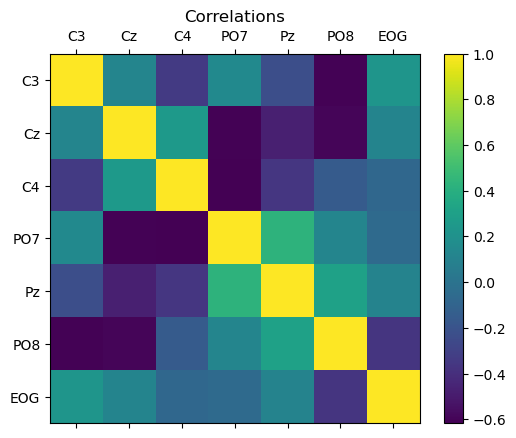

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,1.000000,0.116842,-0.340120,0.148844,-0.227838,-0.608505,0.224793
Cz,0.116842,1.000000,0.257895,-0.604446,-0.472464,-0.595325,0.114139
C4,-0.340120,0.257895,1.000000,-0.616741,-0.363645,-0.153517,-0.078859
PO7,0.148844,-0.604446,-0.616741,1.000000,0.425769,0.116168,-0.060262
Pz,-0.227838,-0.472464,-0.363645,0.425769,1.000000,0.308979,0.106482
PO8,-0.608505,-0.595325,-0.153517,0.116168,0.308979,1.000000,-0.368715
EOG,0.224793,0.114139,-0.078859,-0.060262,0.106482,-0.368715,1.000000


In [75]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Correlations')

plt.show()
df_numerical.corr()

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_7900\3594465532.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_7900\3594465532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


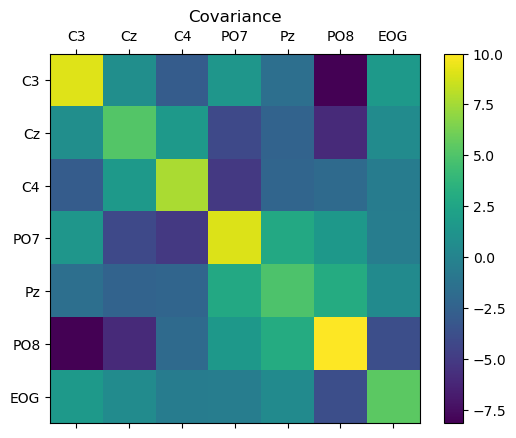

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,9.135905,0.800698,-2.853013,1.353761,-1.524789,-8.145472,1.587660
Cz,0.800698,5.140300,1.622676,-4.123699,-2.371759,-5.977565,0.604683
C4,-2.853013,1.622676,7.701769,-5.150303,-2.234499,-1.886810,-0.511384
PO7,1.353761,-4.123699,-5.150303,9.054611,2.836721,1.548093,-0.423719
Pz,-1.524789,-2.371759,-2.234499,2.836721,4.902479,3.029790,0.550912
PO8,-8.145472,-5.977565,-1.886810,1.548093,3.029790,19.613385,-3.815619
EOG,1.587660,0.604683,-0.511384,-0.423719,0.550912,-3.815619,5.460045


In [76]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.cov(), interpolation='nearest',vmax=10)
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Covariance')

plt.show()
df_numerical.cov()

In [77]:
df_numerical.corr()['EOG'][:-1].mul(df_numerical.std().iloc[:-1]/df_numerical.std().iloc[-1])

C3     0.290778
Cz     0.110747
C4    -0.093659
PO7   -0.077604
Pz     0.100899
PO8   -0.698826
dtype: float64

### 2.1 Visualize Original Data

#### Signal Average Over Epochs

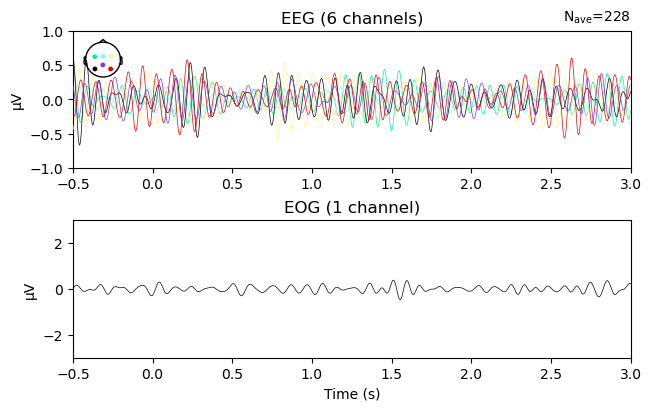

In [78]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-1, 1), eog=(-3, 3)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

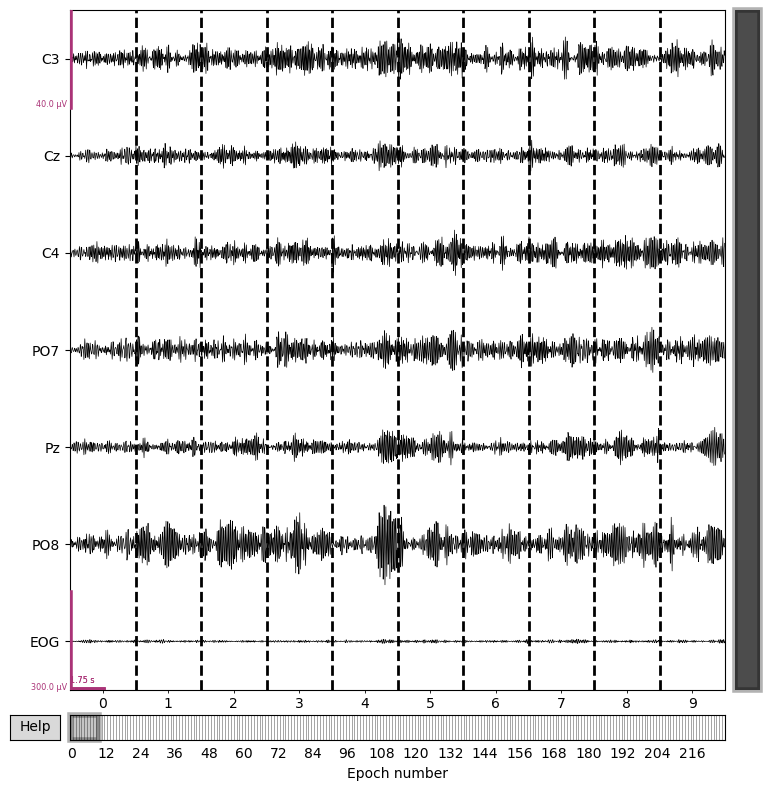

In [79]:
epochs.plot(picks='all', n_epochs=10);

### 2.2 Compute and Apply EOG Regression

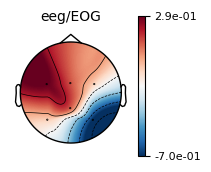

In [80]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)

epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()

fig = model_plain.plot()  # regression coefficients as topomap
fig.set_size_inches(3, 2)

#### Signal Average Over Epochs

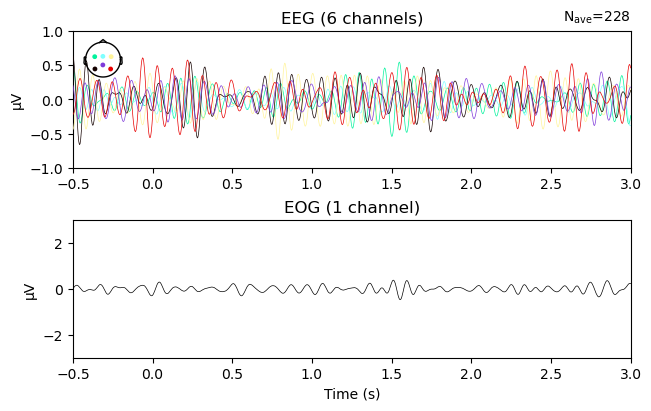

In [81]:
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

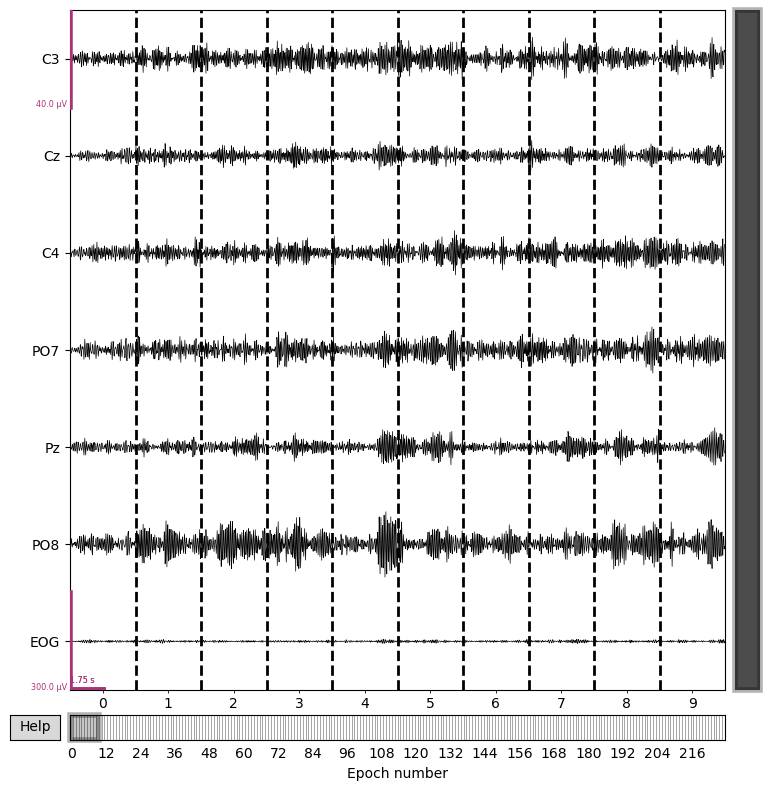

In [82]:
epochs_clean_plain.plot(picks='all', n_epochs=10);

### 2.3 Left vs. Right Classification

Train set shape: (120, 7)
Test set shape : (30, 7)


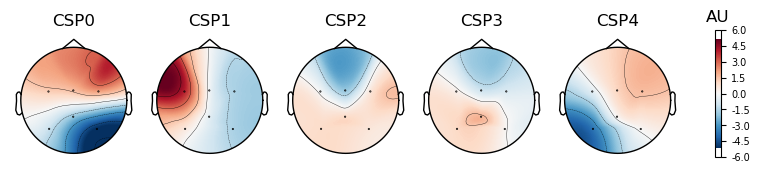

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

       right       0.92      0.73      0.81        15
        left       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [83]:
# Get EEG data and events
X = epochs_clean_plain[['right','left']].get_data(copy=False)
Y = epochs_clean_plain[['right','left']].events[:, -1]

csp_list = []
clf_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    clf = Pipeline([('SVM', SVC(kernel='linear'))])  
    clf.fit(X_train, Y_train)
    clf_list.append(clf)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
clf = clf_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.4 Left vs. Non-left Classification

Train set shape: (182, 7)
Test set shape : (46, 7)


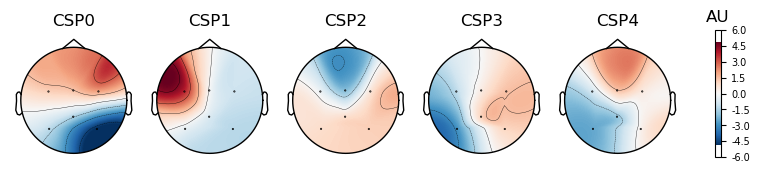

Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

   none-left       0.82      0.90      0.86        31
        left       0.75      0.60      0.67        15

    accuracy                           0.80        46
   macro avg       0.79      0.75      0.76        46
weighted avg       0.80      0.80      0.80        46



In [84]:
epochs_clean_plain_l = epochs_clean_plain.copy()
epochs_clean_plain_l.events = mne.merge_events(epochs_clean_plain_l.events, [0, 1], 0, replace_events=True)
epochs_clean_plain_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_clean_plain_l.get_data(copy=False)
Y = epochs_clean_plain_l.events[:, -1]

csp_list = []
clf_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    clf = Pipeline([('SVM', SVC(kernel='linear'))])  
    clf.fit(X_train, Y_train)
    clf_list.append(clf)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
clf = clf_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.5 Right vs. Non-Right Classification

Train set shape: (182, 7)
Test set shape : (46, 7)


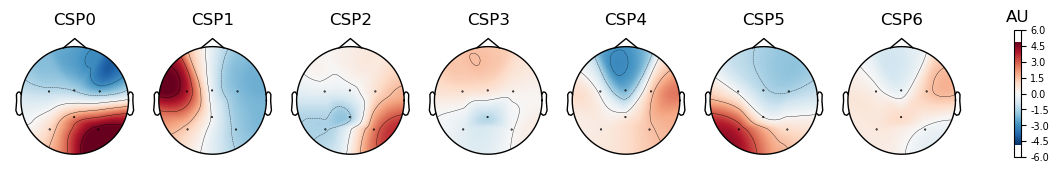

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

  none-right       0.78      0.94      0.85        31
       right       0.78      0.47      0.58        15

    accuracy                           0.78        46
   macro avg       0.78      0.70      0.72        46
weighted avg       0.78      0.78      0.77        46



In [85]:
epochs_clean_plain_r = epochs_clean_plain.copy()
epochs_clean_plain_r.events = mne.merge_events(epochs_clean_plain_r.events, [0, 2], 0, replace_events=True)
epochs_clean_plain_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_clean_plain_r.get_data(copy=False)
Y = epochs_clean_plain_r.events[:, -1]

csp_list = []
clf_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    clf = Pipeline([('SVM', SVC(kernel='linear'))])  
    clf.fit(X_train, Y_train)
    clf_list.append(clf)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
clf = clf_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])